<a href="https://colab.research.google.com/github/italati/AI-Deep-Learning-Lab-2021/blob/ct-body-train/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Automatic Labeling of CT Images
## By: Ian Pan, MD.ai modified by Anouk Stein, MD.ai to predict chest, abdomen, or pelvic slices. Note lower chest/upper abdomen may have labels for both chest and abdomen.



## Import Python packages

In [1]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 5.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!git clone https://github.com/rwfilice/bodypart.git

Cloning into 'bodypart'...
remote: Enumerating objects: 4589, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 4589 (delta 2), reused 9 (delta 2), pack-reused 4580
Receiving objects: 100% (4589/4589), 1.35 GiB | 19.94 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (4581/4581), done.


In [3]:
from scipy.ndimage.interpolation import zoom

import matplotlib.pyplot as plt
import pydicom
import pandas as pd 
import numpy as np 
import glob
import os 
import re 
import json
from pathlib import Path

from keras.applications.imagenet_utils import preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import Model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras import optimizers

import tensorflow as tf 

# Set seed for reproducibility
tf.random.set_seed(88) ; np.random.seed(88) 

# For data augmentation
from albumentations import (
    Compose, OneOf, HorizontalFlip, Blur, RandomGamma, RandomContrast, RandomBrightness
)

In [4]:
print(tf.__version__)

2.7.0


In [5]:
tf.compat.v1.enable_eager_execution()
print(tf.matmul([[1., 2.],[3., 4.]], [[1., 2.],[3., 4.]]))

tf.Tensor(
[[ 7. 10.]
 [15. 22.]], shape=(2, 2), dtype=float32)


In [6]:
imagesPath = Path('bodypart/npy/')
imageList = list(imagesPath.glob('**/*.npy'))
testList = list(sorted(imagesPath.glob('**/5fd4ea78053ef3b10aace7cbf9d70b65*.npy'), key=lambda fn: int(re.search('-([0-9]*)', str(fn)).group(1))))

In [7]:
testPath = Path('bodypart/testnpy')
testList = list(sorted(testPath.glob('**/*.npy'), key=lambda fn: int(re.search('-([0-9]*)', str(fn)).group(1))))

In [8]:
testList

[PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-1.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-2.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-3.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-4.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-5.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-6.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-7.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-8.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-9.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-10.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-11.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-12.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-13.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-14.npy'),
 

In [9]:
df = pd.read_csv("bodypart/labels-overlap.csv")
df

,npyid,labels
0,0794327390645b9f1f50d5962e3f9f5f-1,Chest
1,0794327390645b9f1f50d5962e3f9f5f-2,Chest
2,0794327390645b9f1f50d5962e3f9f5f-3,Chest
3,0794327390645b9f1f50d5962e3f9f5f-4,Chest
4,0794327390645b9f1f50d5962e3f9f5f-5,Chest
...,...,...
4354,ffbb59e078936a9f5a2d02c19e722f46-214,Pelvis
4355,ffbb59e078936a9f5a2d02c19e722f46-215,Pelvis
4356,ffbb59e078936a9f5a2d02c19e722f46-216,Pelvis
4357,ffbb59e078936a9f5a2d02c19e722f46-217,Pelvis


## Locate DICOM images and split data into: training, validation, test

Let's locate all of the images we will use during training. In the previous code block, we kept track of images that the annotator excluded. We remove those images here. The data is structured as: exam (study) > series > images. That is, an exam can have multiple series and a series can have multiple images. The labels are assigned at the exam-level, so we can assume that all images in a series in an exam share the same labels. We split the data based on exams to prevent images from the same patient being distributed across the training, validation, and test data. We split the data into 80% training, 10% validation, 10% test. 

In [10]:
# Define a function to construct training/validation/test splits 
# Split data based on exams to prevent data leak 
# i.e. images from the same patient exist across the splits

def get_train_val_test_split(images, train_frac, val_frac, seed=88):
    '''
    Test fraction will equal 1 - train_frac - val_frac.
    This function splits data based on exams, extracts image file paths,
    and removes images that cannot be read by pydicom.
    '''
    np.random.seed(seed) 
  
    train_images = np.random.choice(images, int(train_frac*len(images)), replace=False)
    not_train_images = list(set(images) - set(train_images)) 
    valid_images = np.random.choice(not_train_images, int(val_frac*len(images)), replace=False)
    test_images = list(set(not_train_images) - set(valid_images)) 
    # Remove images that can't be read by pydicom
    for im in train_images: 
        try: 
            _ = np.load(str(im)) 
        except:
            train_images.remove(im) 
    for im in valid_images: 
        try: 
            _ = np.load(str(im))  
        except:
            valid_images.remove(im) 
    for im in test_images: 
        try: 
            _ = np.load(str(im))  
        except:
            test_images.remove(im) 
    return train_images, valid_images, test_images 
      
# Let's do 3 random train/val/test splits 80%/10%/10%
train0, val0, test0 = get_train_val_test_split(imageList, 0.8, 0.1, seed=0)
train1, val1, test1 = get_train_val_test_split(imageList, 0.8, 0.1, seed=1)
train2, val2, test2 = get_train_val_test_split(imageList, 0.8, 0.1, seed=2)

In [20]:
len(train0),len(val0),len(test0)

(3487, 435, 437)

In [21]:
labels_dict = {'Chest': 0, 
               'Abdomen': 1,
               'Pelvis': 2}
N_CLASSES = len(labels_dict)

## Set up data generation and augmentation

Data generators are an efficient and effective way to load and augment data as it is being passed to the CNN. We convert the DICOM image array into an 8-bit image using a window width of 500 and level of 50. We had previously assigned an integer label to each label in our dataset (e.g., chest, abdomen, pelvis), but the CNN expects binary labels. Thus, for our 7 labels, we convert each integer into a length-7 vector, where each element in the vector is 1 if the image contains that label, 0 otherwise. 

We use simple data augmentation consisting of horizontal flips, random changes to brightness and contrast, and random levels of image blurring to help prevent the CNN from overfitting on the training data. The user should select data augmentations which represent the variability that could occur in a real setting. 

We also examine the class imbalance in our dataset by calculating the frequency of each label in the training data.

In [22]:
def get_dicom_and_uid(path_to_npy):
    '''
    Given a filepath, return the npy file and corresponding SOPInstanceUID. 
    '''
    path_to_npy = str(path_to_npy)
    dicom_file = np.load(path_to_npy)
    uid = path_to_npy.split('/')[-1].replace('.npy', '')
    return dicom_file, uid
  
def convert_dicom_to_8bit(npy_file, width, level, imsize=(224.,224.), clip=True): 
    '''
    Given a DICOM file, window specifications, and image size, 
    return the image as a Numpy array scaled to [0,255] of the specified size. 
    '''
    array = npy_file.copy() 
    #array = array + int(dicom_file.RescaleIntercept) #we did this on preprocess
    #array = array * int(dicom_file.RescaleSlope) #we did this on preprocess
    array = np.clip(array, level - width / 2, level + width / 2)
    # Rescale to [0, 255]
    array -= np.min(array) 
    array /= np.max(array) 
    array *= 255.
    array = array.astype('uint8')
    
    if clip:
    # Sometimes there is dead space around the images -- let's get rid of that
        nonzeros = np.nonzero(array) 
        x1 = np.min(nonzeros[0]) ; x2 = np.max(nonzeros[0])
        y1 = np.min(nonzeros[1]) ; y2 = np.max(nonzeros[1])
        array = array[x1:x2,y1:y2]

    # Resize image if necessary
    resize_x = float(imsize[0]) / array.shape[0] 
    resize_y = float(imsize[1]) / array.shape[1] 
    if resize_x != 1. or resize_y != 1.:
        array = zoom(array, [resize_x, resize_y], order=1, prefilter=False)
    return np.expand_dims(array, axis=-1)

def get_label_from_sop_id(df, uid):
    '''
    Given the annotations dataframe and a study ID, return a one-hot encoded
    vector with labels for that study ID. 
    '''
    df = df[df.npyid == uid] 
    labels = np.zeros((N_CLASSES,))
    for rownum, row in df.iterrows():
        lbls = row.labels.split("-")
        for lbl in lbls:
            label_index = labels_dict[lbl] 
            labels[label_index] += 1 
    return labels

# Data augmentation involves perturbing the images in your training set 
# to prevent overfitting
def augment(p=0.5):
    return Compose([
        HorizontalFlip(p=0.5),
        Blur(p=0.5),
        OneOf([
            RandomGamma(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.5)
    ], p=p)

aug = augment(p=0.5)

def ScoutDataGenerator(df, images, imsize, batchsize, augment=True):
    '''
    Data generator to use with Keras when training. 
    '''
    while True:
        # Shuffle images
        images = np.random.permutation(images) 
        for index in range(0, len(images), batchsize): 
            # Get images 
            image_batch = images[index:(index+batchsize)]
            dicom_and_uids = [get_dicom_and_uid(im) for im in image_batch]
            dicom_files = [_[0] for _ in dicom_and_uids]
            uids = [_[1] for _ in dicom_and_uids] 
            array_list = [] ; uids_list = []
            for ind, dcm in enumerate(dicom_files): 
                try:
                    array_list.append(convert_dicom_to_8bit(dcm, WINDOW_WIDTH, 
                                                  WINDOW_LEVEL, 
                                                  imsize=(imsize,imsize)))
                    uids_list.append(uids[ind])
                except: 
                    continue
        if augment: array_list = [aug(image=arr)['image'] for arr in array_list]
        arrays = np.asarray(array_list)
        # Data are labeled by studies
        # All images in a study share the same label 
        arrays = preprocess_input(arrays, mode='tf')
        labels = np.asarray([get_label_from_sop_id(df, _) for _ in uids_list])
        yield arrays, labels
      

# Let's look at the distribution of labels in the training data
dicom_and_uids = [get_dicom_and_uid(im) for im in train0] 
uids = [_[1] for _ in dicom_and_uids] 
labels = np.asarray([get_label_from_sop_id(df, _) for _ in uids]) 
class_frequencies = np.mean(labels, axis=0) 

category_list = ['Chest', 'Abdomen', 'Pelvis']

for cat_index, cat in enumerate(category_list):
    pct_frequency = round(class_frequencies[cat_index] * 100., 1)
    print('Frequency of {} : {}%'.format(cat, pct_frequency))

Frequency of Chest : 44.7%
Frequency of Abdomen : 32.7%
Frequency of Pelvis : 37.8%


## Set up Keras model

Now we can set up a basic Keras CNN model. We will use the lightweight MobileNetV2 model since our classification problem is relatively simple. Important parameters that can affect model performance include: the initial learning rate (how aggressively the model makes changes to its weights), dropout probability (a method to prevent overfitting by randomly turning neurons in the CNN off), and batch size (the number of images at each iteration to adjust the CNN weights). We use the Adam optimizer, which is a popular optimizer that performs well in most cases. We use an image size of 256 x 256. Oftentimes we would see better performance with higher image sizes up to a point, after which increases in image size do not improve or even worsen performance. However, the tradeoff is that you require more GPU memory and training time. 

Implementing early stopping and a learning rate annealing schedule can help improve performance. A model can quickly overfit and perfectly predict the training data, especially if the model is large and the dataset is small. Early stopping uses validation performance to determine when to stop training: if a model is no longer making improvements on the validation dataset, then stop training. How long we wait and how much progress is considered improvement are both tunable parameters. Reducing the learning rate when validation performance stagnates can also improve model performance. While the initial learning rate should be relatively large to speed up convergence, training using smaller learning rates later on in the process can help the model make smaller adjustments to better fit the specific classification task. In this example, we choose to monitor the validation loss as track changes in the loss to determine when to reduce the learning rate and stop training.

We initialize our model with ImageNet pretrained weights. Our dataset is relatively small so training from scratch (randomly initialized weights) will likely result in worse performance and unstable model training. Even with larger datasets, initializing with pretrained weights can speed up model convergence. Because ImageNet is composed of 3-channel RGB natural color images and our CT scout images are 1-channel grayscale images, we need to slightly modify the first layer of the ImageNet pretrained weights.

Note that we use binary crossentropy as our loss function versus categorical crossentropy. We previously discussed how our problem is multi-label in that a single image can have multiple labels (e.g., chest AND abdomen). Categorical crossentropy is better suited for multi-class problems where an image has only one label. 

In [23]:
#######################
# TRAINING PARAMETERS #
#######################

INITIAL_LR = 1e-4
N_CLASSES  = 3
BATCH_SIZE = 4
DROPOUT    = 0.5
IMSIZE     = 256
# Max number of epochs to train for
EPOCHS     = 50 
# Pick a performance metric to determine whether the model is improving
MONITOR    = 'val_loss' 
# Define a minimum improvement threshold
# The model must improve validation performance by at least this amount 
# to be considered improving
MIN_DELTA  = 0.001 
# If the model is not improving, we should reduce the learning rate 
ANNEAL_BY  = 0.5 
# A model may not improve after 1 epoch but could improve after the next epoch
# without making changes to the learning rate. How many epochs should we wait?
PATIENCE   = 2 
# It can be a good idea to let the model "settle in" to a new learning rate 
# after decreasing it. How long should we wait?
COOLDOWN   = 1
# Stopping model training when the model isn't improving validation performance
# can help prevent overfitting. 
STOP_AFTER = 5

# Load pretrained MobileNetV2 ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
imagenet_weights = base_model.get_weights()
print(imagenet_weights[0].shape) 
# Sum over axis 2 to allow for grayscale (1-channel) input
imagenet_weights[0] = np.expand_dims(np.sum(imagenet_weights[0], axis=2), axis=2)
print(imagenet_weights[0].shape)
base_model = MobileNetV2(weights=None, include_top=False, input_shape=(IMSIZE,IMSIZE,1)) 
base_model.set_weights(imagenet_weights)
x = GlobalAveragePooling2D()(base_model.output) 
x = Dropout(DROPOUT)(x) 
prediction = Dense(N_CLASSES, activation='sigmoid')(x) 

model = Model(inputs=base_model.input, outputs=prediction)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=INITIAL_LR), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

WINDOW_LEVEL, WINDOW_WIDTH = 50, 500
train_scoutgen = ScoutDataGenerator(df, train1, IMSIZE, BATCH_SIZE, augment=True)
valid_scoutgen = ScoutDataGenerator(df, val1, IMSIZE, BATCH_SIZE, augment=False)

9420800/9406464 [==============================] - 0s 0us/step
(3, 3, 3, 32)
(3, 3, 1, 32)


In [24]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Let's take a look at an image produced by our data generator.

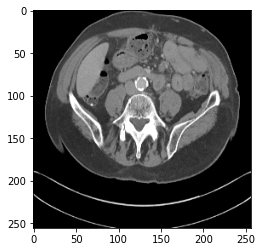

In [25]:
# Show example image
test_image = next(train_scoutgen)[0][0]
plt.imshow(test_image[..., 0], cmap='gray'); plt.show() 

## Training the CNN

Once we have all of our training hyperparameters set up, training the model is simple in Keras. We validate on the validation set after every epoch. 

When we examined the distribution of class labels previously, we saw that there was an imbalance: abdomen and pelvis labels were both >30% whereas lower and upper extremity labels were <10%. Severe class imbalance can cause problems during training as the network will learn to simply predict the more prevalent class. Two common strategies are 1) over-/under-sampling the data so that the distributions of class labels are more similar and 2) using a weighted loss function that gives more weight to less common classes. Though our data is not severely imbalanced, adjusting for class imbalance can still result in small performance boosts. We will use an inverse-frequency weighted loss function during training.

In [26]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [ ]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.8486541499996747
GPU (s):
0.04576006500019503
GPU speedup over CPU: 84x


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15505149711756714593, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11345264640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11759578883334113384
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [ ]:
# this is on just MGUH images starting from scratch
callbacks = [
    EarlyStopping(monitor=MONITOR, patience=STOP_AFTER, min_delta=MIN_DELTA,
                  restore_best_weights=True),
    ReduceLROnPlateau(monitor=MONITOR, factor=ANNEAL_BY, patience=PATIENCE,
                      min_delta=MIN_DELTA, mode='min', cooldown=COOLDOWN, 
                      verbose=1)
]

# Let's weight each class in the loss function by the inverse of its frequency
weights = {} ; total_weight = 0.
for freq_index, freq in enumerate(class_frequencies): 
    weights[freq_index] = 1. / freq
    total_weight += weights[freq_index]

# Scale so that sum of weights equals the number of classes
for each_class in weights.keys(): 
    weights[each_class] = weights[each_class] / total_weight * N_CLASSES

model.fit_generator(train_scoutgen, epochs=EPOCHS, 
                    steps_per_epoch=len(train1) / BATCH_SIZE, 
                    validation_data=valid_scoutgen, 
                    validation_steps=len(val1) / BATCH_SIZE,
                    callbacks=callbacks,
                    class_weight=weights) 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
421/871 [=============>................] - ETA: 3:28:39 - loss: 0.4075 - accuracy: 0.7229

In [ ]:
title = "mguh-multilabel.h5"
model.save_weights(title)

In [ ]:
model.load_weights('weights_slices_2.h5')

In [ ]:
# this is starting with TCGA/Anouk weights and then training on MGUH data
callbacks = [
    EarlyStopping(monitor=MONITOR, patience=STOP_AFTER, min_delta=MIN_DELTA,
                  restore_best_weights=True),
    ReduceLROnPlateau(monitor=MONITOR, factor=ANNEAL_BY, patience=PATIENCE,
                      min_delta=MIN_DELTA, mode='min', cooldown=COOLDOWN, 
                      verbose=1)
]

# Let's weight each class in the loss function by the inverse of its frequency
weights = {} ; total_weight = 0.
for freq_index, freq in enumerate(class_frequencies): 
    weights[freq_index] = 1. / freq
    total_weight += weights[freq_index]

# Scale so that sum of weights equals the number of classes
for each_class in weights.keys(): 
    weights[each_class] = weights[each_class] / total_weight * N_CLASSES

model.fit_generator(train_scoutgen, epochs=EPOCHS, 
                    steps_per_epoch=len(train1) / BATCH_SIZE, 
                    validation_data=valid_scoutgen, 
                    validation_steps=len(val1) / BATCH_SIZE,
                    callbacks=callbacks,
                    class_weight=weights) 

In [ ]:
title = "tcga-mguh-multilabel.h5"
model.save_weights(title)

In [ ]:
!ls

## Predict on test set

Now let's evaluate predictions on the test data. Note that the CNN predicts labels for each image but labels exist at an exam-level. Thus we need to combine predictions for each image in an exam to produce an exam-level label. We will do so by simply averaging the prediction scores across all images in an exam. 

In [ ]:
model.load_weights('mguh-multilabel.h5')  #Just Georgetown

In [ ]:
model.load_weights('tcga-mguh-multilabel.h5')  #federated

In [ ]:
def predict_test(model, df, images, imsize):
    '''
    Small modifications to data generator to allow for prediction on test data.
    '''
    test_arrays = [] 
    test_labels = [] 
    test_probas = [] 
    test_uids   = []
    for im in images: 
        dicom_file, uid = get_dicom_and_uid(im) 
        try:
            array = convert_dicom_to_8bit(dicom_file, WINDOW_WIDTH, WINDOW_LEVEL, 
                                    imsize=(imsize,imsize))
        except: 
            continue
        # Data are labeled by studies
        # All images in a study share the same label 
        array = preprocess_input(array, mode='tf')
        label = get_label_from_sop_id(df, uid)
        test_arrays.append(array) 
        test_labels.append(label)
        test_probas.append(model.predict(np.expand_dims(array, axis=0)))
        test_uids.append(uid)
    return test_uids, test_arrays, test_labels, test_probas
                                    
uids, X, y_true, y_prob = predict_test(model, df, test0, IMSIZE)
# Predictions are made at the image level
# We need to combine image-level predictions and get exam-level predictions
# We will simply average the predictions for each image in the exam 
# to get exam-level predictions
test_pred_df = pd.DataFrame({'uid': uids, 'X': X, 'y_true': y_true, 
                             'y_prob': y_prob})
test_pred_by_uid = [_[1] for _ in list(test_pred_df.groupby('uid'))]

uids = []
X = [] 
y_prob = [] 
y_true = [] 
for each_df in test_pred_by_uid: 
    uids.append(each_df.uid.values[0])
    row_counter = 0.
    tmp_y_prob = np.zeros((N_CLASSES,)).astype('float32') 
    y_true.append(each_df.y_true.values[0])
    tmp_X = []
    for rownum, row in each_df.iterrows():
        row_counter += 1. 
        tmp_y_prob += row.y_prob[0]
        tmp_X.append(row.X) 
    X.append(tmp_X) 
    y_prob.append(tmp_y_prob / row_counter)

y_pred = [] 
for p in y_prob: 
    tmp_pred = np.round(p) 
    # Prediction can't be all zeros, so lower threshold if it is
    threshold = 0.5
    while np.sum(tmp_pred) == 0: 
        threshold -= 0.05
        tmp_pred = p >= threshold 
    y_pred.append(tmp_pred.astype('float32'))

Let's take a look at how many exams were perfectly predicted. All labels must be correctly predicted to count as a correct prediction. 

In [ ]:
# All labels must be correctly predicted to be count as a correct prediction
correct = 0 
for index, i in enumerate(y_pred): 
    if np.sum(i == y_true[index]) == N_CLASSES: correct += 1

print('{}% of test image predictions are completely correct'.format(round(float(correct) / len(y_pred) * 100., 1)))

In [ ]:
# federated All labels must be correctly predicted to be count as a correct prediction
correct = 0 
for index, i in enumerate(y_pred): 
    if np.sum(i == y_true[index]) == N_CLASSES: correct += 1

print('{}% of test image predictions are completely correct'.format(round(float(correct) / len(y_pred) * 100., 1)))

How about partially correct predictions? We define partially correct as having at least one correct overlapping label. 

In [ ]:
part_correct = 0 
for index, i in enumerate(y_pred): 
    if np.sum((i == 1) & (y_true[index] == 1)) > 0: part_correct += 1

print('{}% of test image predictions are partially correct'.format(round(float(part_correct) / len(y_pred) * 100., 1)))

In [ ]:
#federated
part_correct = 0 
for index, i in enumerate(y_pred): 
    if np.sum((i == 1) & (y_true[index] == 1)) > 0: part_correct += 1

print('{}% of test image predictions are partially correct'.format(round(float(part_correct) / len(y_pred) * 100., 1)))

Now, let's examine accuracy for each class. That is, for each class, how many images were correctly predicted to be positive or negative for that label? This is the binary classification accuracy for each category.

In [ ]:
# Next, let's category-level accuracy
# For each category (i.e. exam type), what percentage of images were 
# correctly predicted to be in that category? 

category_list = ['CHEST', 'ABDOMEN', 'PELVIS']

category_correct_list = [] 
for category_index in range(len(category_list)): 
    correct = 0 
    for index, i in enumerate(y_pred): 
        if i[category_index] == y_true[index][category_index]: correct += 1
    category_correct_list.append(round(float(correct) / len(y_pred) * 100., 1))
  
for cat_index, each_cat in enumerate(category_list):
    print('{}% of images were correctly labeled with: {}'.format(category_correct_list[cat_index], each_cat))

In [ ]:
#federated
# Next, let's category-level accuracy
# For each category (i.e. exam type), what percentage of images were 
# correctly predicted to be in that category? 

category_list = ['CHEST', 'ABDOMEN', 'PELVIS']

category_correct_list = [] 
for category_index in range(len(category_list)): 
    correct = 0 
    for index, i in enumerate(y_pred): 
        if i[category_index] == y_true[index][category_index]: correct += 1
    category_correct_list.append(round(float(correct) / len(y_pred) * 100., 1))
  
for cat_index, each_cat in enumerate(category_list):
    print('{}% of images were correctly labeled with: {}'.format(category_correct_list[cat_index], each_cat))

This shows that the model is fairly accurate when we look at individual classes. One might expect that CT scout images that contain parts of different regions but were not labeled as such would be more difficult to predict accurately. For example, if half of the thorax was present in an image, it might not have been labeled as chest -- but the presence of part of the thorax could lead the model to make that prediction. Let's examine our incorrect test predictions.

In [ ]:
# Let's take a look at some incorrect predictions

def convert_numbers_to_words(label, category_list):
    return ' | '.join(list(np.asarray(category_list)[label.astype('bool')]))
  

def show_predictions(img, uid, y_true, y_pred, category_list): 
    if len(img) == 1:
        fig = plt.figure(figsize=(8,8))
    else:
        fig = plt.figure(figsize=(8,6))
    y_true = convert_numbers_to_words(y_true, category_list)
    y_pred = convert_numbers_to_words(y_pred, category_list) 
    fig.suptitle('{}\nACTUAL: {}\nPREDICTED: {}'.format(uid, y_true, y_pred))
    for im_index, im in enumerate(img): 
        ax = fig.add_subplot(1,len(img),im_index+1)
        ax.imshow(im[..., 0], cmap='gray')
    plt.show() 
  
incorrect_predictions = []
for index, i in enumerate(y_pred): 
    if np.sum(i == y_true[index]) < N_CLASSES: 
        incorrect_predictions.append(index)

for im2show in incorrect_predictions:
    show_predictions(X[im2show], 
                   uids[im2show], 
                   y_true[im2show], 
                   y_pred[im2show], 
                   category_list)

In [ ]:
#federated
# Let's take a look at some incorrect predictions

def convert_numbers_to_words(label, category_list):
    return ' | '.join(list(np.asarray(category_list)[label.astype('bool')]))
  

def show_predictions(img, uid, y_true, y_pred, category_list): 
    if len(img) == 1:
        fig = plt.figure(figsize=(8,8))
    else:
        fig = plt.figure(figsize=(8,6))
    y_true = convert_numbers_to_words(y_true, category_list)
    y_pred = convert_numbers_to_words(y_pred, category_list) 
    fig.suptitle('{}\nACTUAL: {}\nPREDICTED: {}'.format(uid, y_true, y_pred))
    for im_index, im in enumerate(img): 
        ax = fig.add_subplot(1,len(img),im_index+1)
        ax.imshow(im[..., 0], cmap='gray')
    plt.show() 
  
incorrect_predictions = []
for index, i in enumerate(y_pred): 
    if np.sum(i == y_true[index]) < N_CLASSES: 
        incorrect_predictions.append(index)

for im2show in incorrect_predictions:
    show_predictions(X[im2show], 
                   uids[im2show], 
                   y_true[im2show], 
                   y_pred[im2show], 
                   category_list)

We can see from our incorrect predictions that for the most part our model makes sensible incorrect predictions (omitting/adding regions that are partially present).

That concludes this notebook. We trained a basic CNN to label CT scout exams with their anatomical regions. Feel free to read up on tips and tricks for further improving model performance and tackling more difficult problems. There are plenty of openly available resources on the Internet!

In [ ]:
#Inference
def predict(model, images, imsize):
    '''
    Small modifications to data generator to allow for prediction on test data.
    '''
    test_arrays = [] 
 
    test_probas = [] 
    test_uids   = []
    for im in images: 
        dicom_file, uid = get_dicom_and_uid(im) 
        try:
            array = convert_dicom_to_8bit(dicom_file, WINDOW_WIDTH, WINDOW_LEVEL, 
                                    imsize=(imsize,imsize))
        except: 
            continue
      
        array = preprocess_input(array, mode='tf')
        test_arrays.append(array) 

        test_probas.append(model.predict(np.expand_dims(array, axis=0)))
        test_uids.append(uid)
    return test_uids, test_arrays, test_probas

imagesForInference = imageList[0:10]
                                    
#uids, X, y_prob = predict(model, imagesForInference, IMSIZE)
uids, X, y_prob = predict(model, testList, IMSIZE)
# Predictions are made at the image level

test_pred_df = pd.DataFrame({'uid': uids, 'X': X, 'y_prob': y_prob})

In [ ]:
test_pred_df

In [ ]:
test_pred_df.apply(lambda row: row['y_prob'], axis=1)

In [ ]:
chest = np.stack(test_pred_df['y_prob'])[:,0][:,0]
abd = np.stack(test_pred_df['y_prob'])[:,0][:,1]
pelv = np.stack(test_pred_df['y_prob'])[:,0][:,2]

Below I'm testing on a completely random denovo/naive MGUH CT dataset

In [ ]:
#raw MGUH
plt.plot(chest)
plt.plot(abd)
plt.plot(pelv)

In [ ]:
#raw TCGA-MGUH
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.set_xlabel("Slice Number", fontsize=20)
ax1.set_ylabel("Confidence", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(chest,linewidth=2,label="Chest")
plt.plot(abd,linewidth=2,label="Abdomen")
plt.plot(pelv,linewidth=2,label="Pelvis")
plt.legend(fontsize=16)

In [ ]:
numaveslices = 5
avepreds = []
allpreds = np.stack(test_pred_df['y_prob'])[:,0]
for idx,arr in enumerate(allpreds):
    low = int(max(0,idx-(numaveslices-1)/2))
    high = int(min(len(allpreds),idx+(numaveslices+1)/2))
    avepreds.append(np.mean(allpreds[low:high],axis=0))
    
chest = np.stack(avepreds)[:,0]
abd = np.stack(avepreds)[:,1]
pelv = np.stack(avepreds)[:,2]

In [ ]:
#MGUH averaged over 5 slices
plt.plot(chest)
plt.plot(abd)
plt.plot(pelv)

In [ ]:
#TCGA-MGUH averaged over 5 slices
fig, ax1 = plt.subplots(figsize=(17,10))
ax1.set_xlabel("Slice Number", fontsize=20)
ax1.set_ylabel("Confidence", fontsize=20)
plt.xticks([0,30,60,90,120,150,180,210],fontsize=12)
plt.yticks(fontsize=12)
ax1.axvline(30,color='gray',ymax=0.1)
ax1.axvline(82,color='gray',ymax=0.1)
ax1.axvline(120,color='gray',ymax=0.1)
ax1.axvline(172,color='gray',ymax=0.1)
ax1.axvline(195,color='gray',ymax=0.1)
plt.plot(chest,linewidth=2,label="Chest")
plt.plot(abd,linewidth=2,label="Abdomen")
plt.plot(pelv,linewidth=2,label="Pelvis")
plt.legend(fontsize=16)

In [ ]:
displayImages([testList[30],testList[82],testList[120],testList[172],testList[195]],[30,82,120,172,195])

In [ ]:
#MGUH averaged over 9 slices
plt.plot(chest)
plt.plot(abd)
plt.plot(pelv)

In [ ]:
#TCGA-MGUH averaged over 9 slices
plt.plot(chest)
plt.plot(abd)
plt.plot(pelv)

In [ ]:
def displayImage(file):
    dicom_file, uid = get_dicom_and_uid(file)
    img = convert_dicom_to_8bit(dicom_file, WINDOW_WIDTH, WINDOW_LEVEL, clip=False)
    plt.imshow(img[..., 0], cmap='gray'); plt.show()

In [ ]:
displayImage(testList[0])

In [ ]:
def displayImages(imgs,labels):
    numimgs = len(imgs)
    plt.figure(figsize=(20,10))
    for idx,img in enumerate(imgs):
        dicom_file, uid = get_dicom_and_uid(img)
        img = convert_dicom_to_8bit(dicom_file, WINDOW_WIDTH, WINDOW_LEVEL, clip=False)
        plt.subplot("1%i%i" % (numimgs,idx+1))
        plt.imshow(img[...,0],cmap='gray')
        plt.title(labels[idx])
        plt.axis('off')

In [ ]:
#chest/abd border
displayImages(testList[66:72])

In [ ]:
displayImages(testList[75:81])

In [ ]:
#abd/pelv
displayImages(testList[132:138])